In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'

import jax
#jax.config.update('jax_default_device', jax.devices('cpu')[0])

from jax import random, jit, vmap, grad
from jax import numpy as jnp
from jax.lax import cond

import astropy
import numpy as np
import healpy as hp

import h5py
import astropy.units as u

from astropy.cosmology import Planck15, FlatLambdaCDM, z_at_value
import astropy.constants as constants
from jax.scipy.special import logsumexp
from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde
from tqdm import tqdm
from models import *

import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = 'Times New Roman'
matplotlib.rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['figure.figsize'] = (16.0, 10.0)
matplotlib.rcParams['axes.unicode_minus'] = False

import seaborn as sns
sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('colorblind')
c=sns.color_palette('colorblind')

jax.config.update("jax_enable_x64", True)
jax.config.update('jax_default_matmul_precision', 'highest')


2025-02-14 18:18:50.068110: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.3 which is older than the PTX compiler version 12.6.77. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
100%|██████████| 50/50 [00:00<00:00, 194.28it/s]


In [2]:
from jaxinterp2d import interp2d, CartesianGrid

H0Planck = Planck15.H0.value
Om0Planck = Planck15.Om0

zMax = 5
zgrid = jnp.expm1(jnp.linspace(jnp.log(1), jnp.log(zMax+1), 1000))
Om0grid = jnp.linspace(Om0Planck-0.1,Om0Planck+0.1,50)

cosmo = FlatLambdaCDM(H0=H0Planck,Om0=Planck15.Om0)
speed_of_light = constants.c.to('km/s').value

rs = []
for Om0 in tqdm(Om0grid):
    cosmo = FlatLambdaCDM(H0=H0Planck,Om0=Om0)
    rs.append(cosmo.comoving_distance(zgrid).to(u.Mpc).value)

rs = jnp.asarray(rs)
rs = rs.reshape(len(Om0grid),len(zgrid))

@jit
def E(z,Om0=Om0Planck):
    return jnp.sqrt(Om0*(1+z)**3 + (1.0-Om0))

@jit
def r_of_z(z,H0,Om0=Om0Planck):
    return interp2d(Om0,z,Om0grid,zgrid,rs)*(H0Planck/H0)

@jit
def dL_of_z(z,H0,Om0=Om0Planck):
    return (1+z)*r_of_z(z,H0,Om0)

@jit
def z_of_dL(dL,H0,Om0=Om0Planck):
    return jnp.interp(dL,dL_of_z(zgrid,H0,Om0),zgrid)

@jit
def dV_of_z(z,H0,Om0=Om0Planck):
    return speed_of_light*r_of_z(z,H0,Om0)**2/(H0*E(z,Om0))

@jit
def ddL_of_z(z,dL,H0,Om0=Om0Planck):
    return dL/(1+z) + speed_of_light*(1+z)/(H0*E(z,Om0))

100%|██████████| 50/50 [00:00<00:00, 715.55it/s]


In [3]:
from gwpopulation.models import mass as mass_models
import bilby
from scipy.integrate import cumtrapz

Nsamples = 10000

underlying_pop = {"mmin": 6, "alpha": 4, "beta_q": 1.5, "mmax": 70, "lam": 0.04, "mpp": 35, "sigpp": 4, "delta_m": 4.0, "lamb": 3}

ms = np.linspace(0.1, 150, 1000)

m1_pdf = mass_models.SinglePeakSmoothedMassDistribution().p_m1({"mass_1":ms}, 
                                                        alpha=underlying_pop["alpha"],
                                                        mmin=underlying_pop["mmin"],
                                                        delta_m=underlying_pop["delta_m"],
                                                        mpp=underlying_pop["mpp"],                                             
                                                        sigpp=underlying_pop["sigpp"],
                                                        mmax=underlying_pop["mmax"],
                                                        lam=underlying_pop["lam"])


m1_cdf = cumtrapz(m1_pdf, ms, initial=0)
m1_cdf/=m1_cdf[-1]

m1_samples = interp1d(m1_cdf,ms)(np.random.rand(Nsamples))

m1_samples = m1_samples[np.where(m1_samples>underlying_pop["mmin"])[0]]
Nsamples = len(m1_samples)


q_samples = np.array([bilby.core.prior.analytical.PowerLaw(alpha=underlying_pop['beta_q'],
                                                           minimum=underlying_pop["mmin"]/m1, maximum=1).sample(size=1)[0] for m1 in m1_samples])


m1s,m2s = np.meshgrid(ms,ms)


pm1s = mass_models.SinglePeakSmoothedMassDistribution().p_m1( {"mass_1":m1s},
                                                        alpha=underlying_pop["alpha"],
                                                        mmin=underlying_pop["mmin"],
                                                        delta_m=underlying_pop["delta_m"],
                                                        mpp=underlying_pop["mpp"],                                             
                                                        sigpp=underlying_pop["sigpp"],
                                                        mmax=underlying_pop["mmax"],
                                                        lam=underlying_pop["lam"])
pqs = mass_models.SinglePeakSmoothedMassDistribution().p_q({"mass_1":m1s,"mass_ratio":m2s/m1s},beta=underlying_pop['beta_q'],delta_m=underlying_pop["delta_m"],mmin=underlying_pop["mmin"])
pm1m2s = pm1s*pqs/m1s
pm1m2s[m1s<m2s]=0.
pm1m2s/=np.trapz(np.trapz(pm1m2s,ms,axis=0),ms)

pm1=np.trapz(pm1m2s,ms,axis=0)
pm2=np.trapz(pm1m2s,ms,axis=1)

pm1 = pm1/np.trapz(pm1,ms)
pm2 = pm2/np.trapz(pm2,ms)

/tmp/ipykernel_3267869/2742483424.py:21: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  m1_cdf = cumtrapz(m1_pdf, ms, initial=0)
/hildafs/home/magana/tmp_ondemand_hildafs_phy230014p_symlink/magana/.conda/envs/jax/lib/python3.11/site-packages/gwpopulation/models/mass.py:631: RuntimeWarning: invalid value encountered in divide
  p_q /= self.norm_p_q(beta=beta, mmin=mmin, delta_m=delta_m)


In [4]:
import pickle
from dynesty.utils import resample_equal
from dynesty import NestedSampler, DynamicNestedSampler
import multiprocessing as multi
import corner 

dlogz_plbump = []
dlogz_plbump_err = []
post_samples_plbump = []

file = open('PLB','rb')
dres = pickle.load(file)

dlogZdynesty = dres.logz[-1]        # value of logZ
dlogZerrdynesty = dres.logzerr[-1]  # estimate of the statistcal uncertainty on logZ

dlogz_plbump.append(dlogZdynesty)
dlogz_plbump_err.append(dlogZerrdynesty)

# output marginal likelihood
print('Marginalised evidence (using dynamic sampler) is {} ± {}'.format(dlogZdynesty, dlogZerrdynesty))

# get the posterior samples
dweights = np.exp(dres['logwt'] - dres['logz'][-1])
dpostsamples = resample_equal(dres.samples, dweights)
post_samples_plbump.append(dpostsamples)
print('Number of posterior samples (using dynamic sampler) is {}'.format(dpostsamples.shape[0]))


Marginalised evidence (using dynamic sampler) is -1519.508137992134 ± 0.05788562960409826
Number of posterior samples (using dynamic sampler) is 69148


In [5]:
@jit
def log_pm1m2_powerlaw_peak(m1,m2,m_min_1,m_max_1,alpha_1,dm_min_1,dm_max_1,mu,sigma,f1,beta):
    log_dNdm1 = logpm1_powerlaw_peak(m1,m_min_1,m_max_1,alpha_1,dm_min_1,dm_max_1,mu,sigma,f1)
    log_dNdm2 = logpm1_powerlaw_peak(m2,m_min_1,m_max_1,alpha_1,dm_min_1,dm_max_1,mu,sigma,f1)
    log_fq = logfq(m1,m2,beta)
    return log_dNdm1 + log_dNdm2 + log_fq 

plbump_pm1s = []
plbump_pm2s = []
for k in tqdm(range(len(post_samples_plbump[0]))):
    
    dpostsamples = post_samples_plbump[0][k]
    
    gamma_1 = dpostsamples[0]
    mmin_1 = dpostsamples[1]
    mmax_1 = dpostsamples[2]
    alpha_1 = dpostsamples[3]
    dm_mmin_1 = dpostsamples[4]
    dm_mmax_1 = dpostsamples[5]
    beta = dpostsamples[6]
    mu = dpostsamples[7]
    sigma = dpostsamples[8]
    f1 = dpostsamples[9]
    
    pm1sm2s_fit = np.exp(log_pm1m2_powerlaw_peak(m1s,m2s,mmin_1,mmax_1,alpha_1,dm_mmin_1,dm_mmax_1,mu,sigma,f1,beta))
    pm1sm2s_fit[m1s<m2s]=0.
    pm1sm2s_fit/=np.trapz(np.trapz(pm1sm2s_fit,ms,axis=0),ms)    
    pm1_fit = np.trapz(pm1sm2s_fit,ms,axis=0)
    pm2_fit = np.trapz(pm1sm2s_fit,ms,axis=1)    
    pm1_fit = pm1_fit/np.trapz(pm1_fit,ms)
    pm2_fit = pm2_fit/np.trapz(pm2_fit,ms)
    plbump_pm1s.append(pm1_fit)
    plbump_pm2s.append(pm2_fit)

100%|██████████| 69148/69148 [33:11<00:00, 34.71it/s]


100%|██████████| 69148/69148 [00:30<00:00, 2274.09it/s]


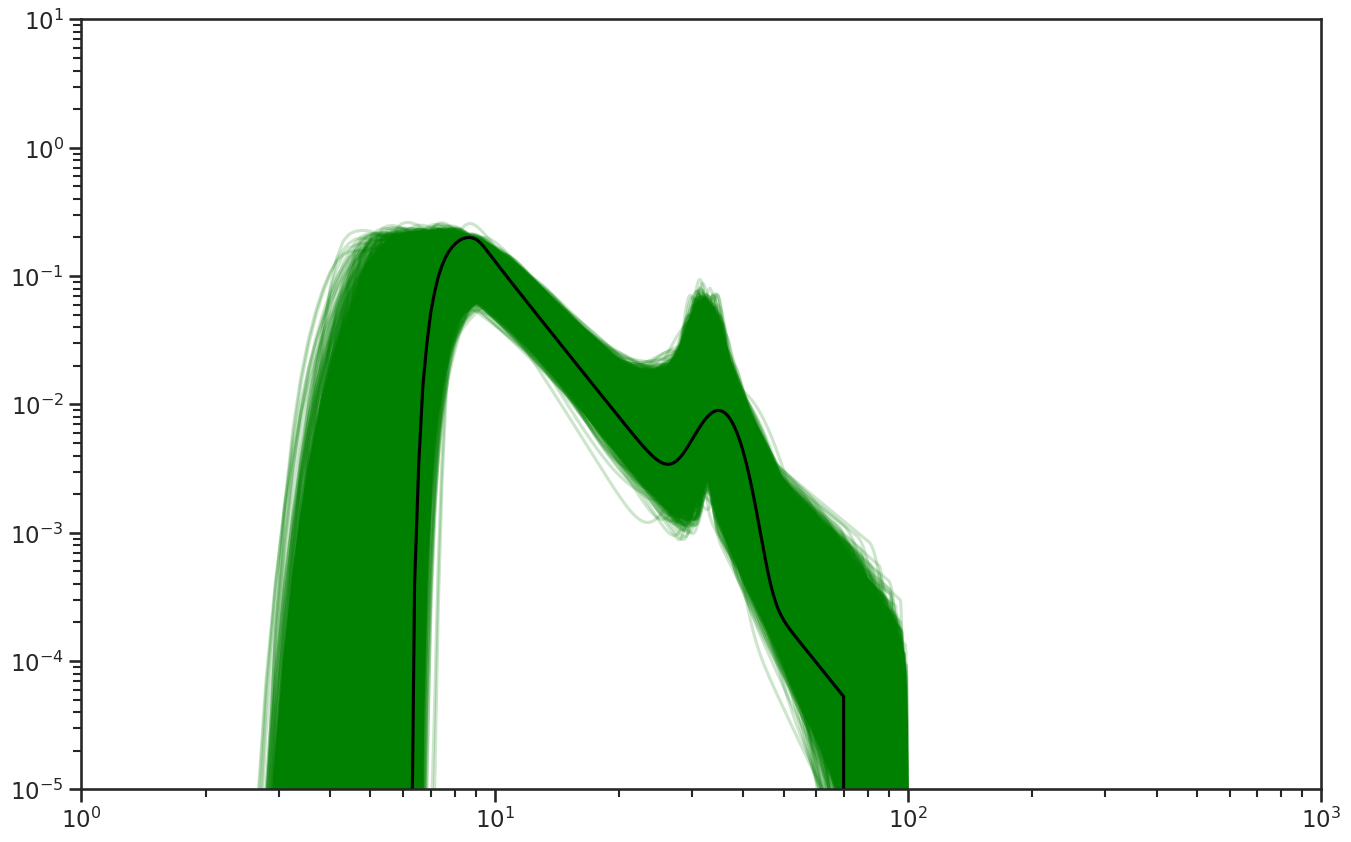

100%|██████████| 69148/69148 [00:33<00:00, 2084.89it/s]


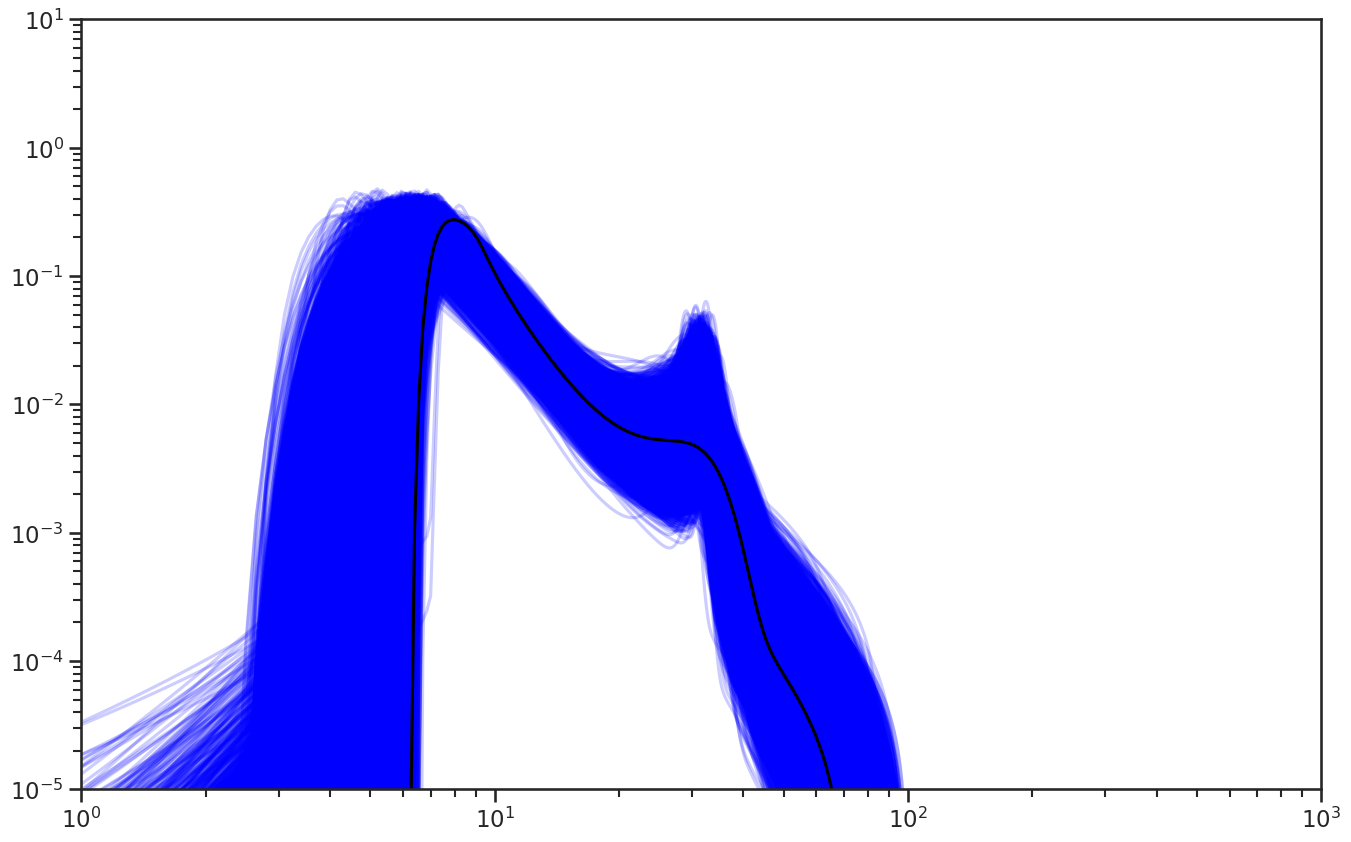

In [6]:
plt.figure()
for pm1_fit in tqdm(plbump_pm1s):
    plt.loglog(ms,pm1_fit,alpha=0.2,color='green')    
plt.loglog(ms,pm1,color='black')
plt.xlim(1,1000)
plt.ylim(1e-5,10)
plt.show()

plt.figure()
for pm2_fit in tqdm(plbump_pm2s):
    plt.loglog(ms,pm2_fit,alpha=0.2,color='blue')    
plt.loglog(ms,pm2,color='black')
plt.xlim(1,1000)
plt.ylim(1e-5,10)
plt.show()

In [7]:
dlogz_plplbump = []
dlogz_plplbump_err = []
post_samples_plplbump = []

file = open('PLPLB','rb')
dres = pickle.load(file)

dlogZdynesty = dres.logz[-1]        # value of logZ
dlogZerrdynesty = dres.logzerr[-1]  # estimate of the statistcal uncertainty on logZ

dlogz_plplbump.append(dlogZdynesty)
dlogz_plplbump_err.append(dlogZerrdynesty)

# output marginal likelihood
print('Marginalised evidence (using dynamic sampler) is {} ± {}'.format(dlogZdynesty, dlogZerrdynesty))

# get the posterior samples
dweights = np.exp(dres['logwt'] - dres['logz'][-1])
dpostsamples = resample_equal(dres.samples, dweights)
post_samples_plplbump.append(dpostsamples)
print('Number of posterior samples (using dynamic sampler) is {}'.format(dpostsamples.shape[0]))


Marginalised evidence (using dynamic sampler) is -1518.8368810963589 ± 0.06394353443738376
Number of posterior samples (using dynamic sampler) is 69693


In [8]:
def log_pm1m2_powerlaw_powerlaw_peak(m1,m2,m_min_1,m_max_1,alpha_1,dm_min_1,dm_max_1,m_min_2,m_max_2,alpha_2,dm_min_2,dm_max_2,mu,sigma,f1,f2,beta):
    log_dNdm1 = logpm1_powerlaw_powerlaw_peak(m1,m_min_1,m_max_1,alpha_1,dm_min_1,dm_max_1,m_min_2,m_max_2,alpha_2,dm_min_2,dm_max_2,mu,sigma,f1,f2)
    log_dNdm2 = logpm1_powerlaw_powerlaw_peak(m2,m_min_1,m_max_1,alpha_1,dm_min_1,dm_max_1,m_min_2,m_max_2,alpha_2,dm_min_2,dm_max_2,mu,sigma,f1,f2)
    log_fq = logfq(m1,m2,beta)
    return log_dNdm1 + log_dNdm2 + log_fq


plplbump_pm1s = []
plplbump_pm2s = []

for k in tqdm(range(len(post_samples_plplbump[0]))):
    
    dpostsamples = post_samples_plplbump[0][k]
    
    gamma_1 = dpostsamples[0]
    mmin_1 = dpostsamples[1]
    mmax_1 = dpostsamples[2]
    alpha_1 = dpostsamples[3]
    dm_mmin_1 = dpostsamples[4]
    dm_mmax_1 = dpostsamples[5]
    mmin_2 = dpostsamples[6]
    mmax_2 = dpostsamples[7]
    alpha_2 = dpostsamples[8]
    dm_mmin_2 = dpostsamples[9]
    dm_mmax_2 = dpostsamples[10]
    beta = dpostsamples[11]
    mu = dpostsamples[12]
    sigma = dpostsamples[13]
    f1 = dpostsamples[14]
    f2 = dpostsamples[15]
    
    pm1sm2s_fit = np.exp(log_pm1m2_powerlaw_powerlaw_peak(m1s,m2s,mmin_1,mmax_1,alpha_1,dm_mmin_1,dm_mmax_1,mmin_2,mmax_2,alpha_2,dm_mmin_2,dm_mmax_2,mu,sigma,f1,f2,beta))
    pm1sm2s_fit[m1s<m2s]=0.
    pm1sm2s_fit/=np.trapz(np.trapz(pm1sm2s_fit,ms,axis=0),ms)    
    pm1_fit = np.trapz(pm1sm2s_fit,ms,axis=0)
    pm2_fit = np.trapz(pm1sm2s_fit,ms,axis=1)    
    pm1_fit = pm1_fit/np.trapz(pm1_fit,ms)
    pm2_fit = pm2_fit/np.trapz(pm2_fit,ms)
    plplbump_pm1s.append(pm1_fit)
    plplbump_pm2s.append(pm2_fit)


100%|██████████| 69693/69693 [34:55<00:00, 33.26it/s]


100%|██████████| 69693/69693 [00:33<00:00, 2056.68it/s]


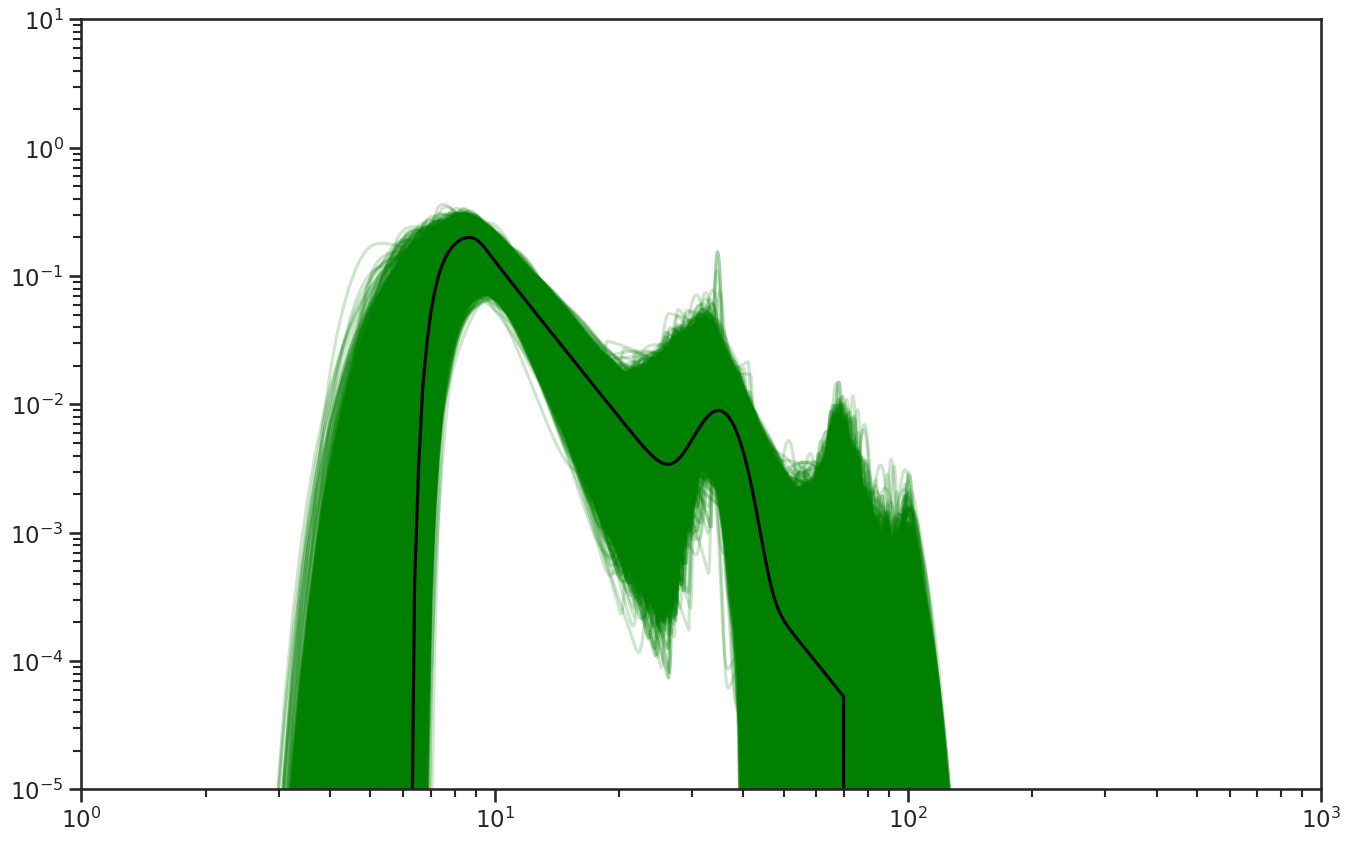

100%|██████████| 69693/69693 [00:32<00:00, 2124.45it/s]


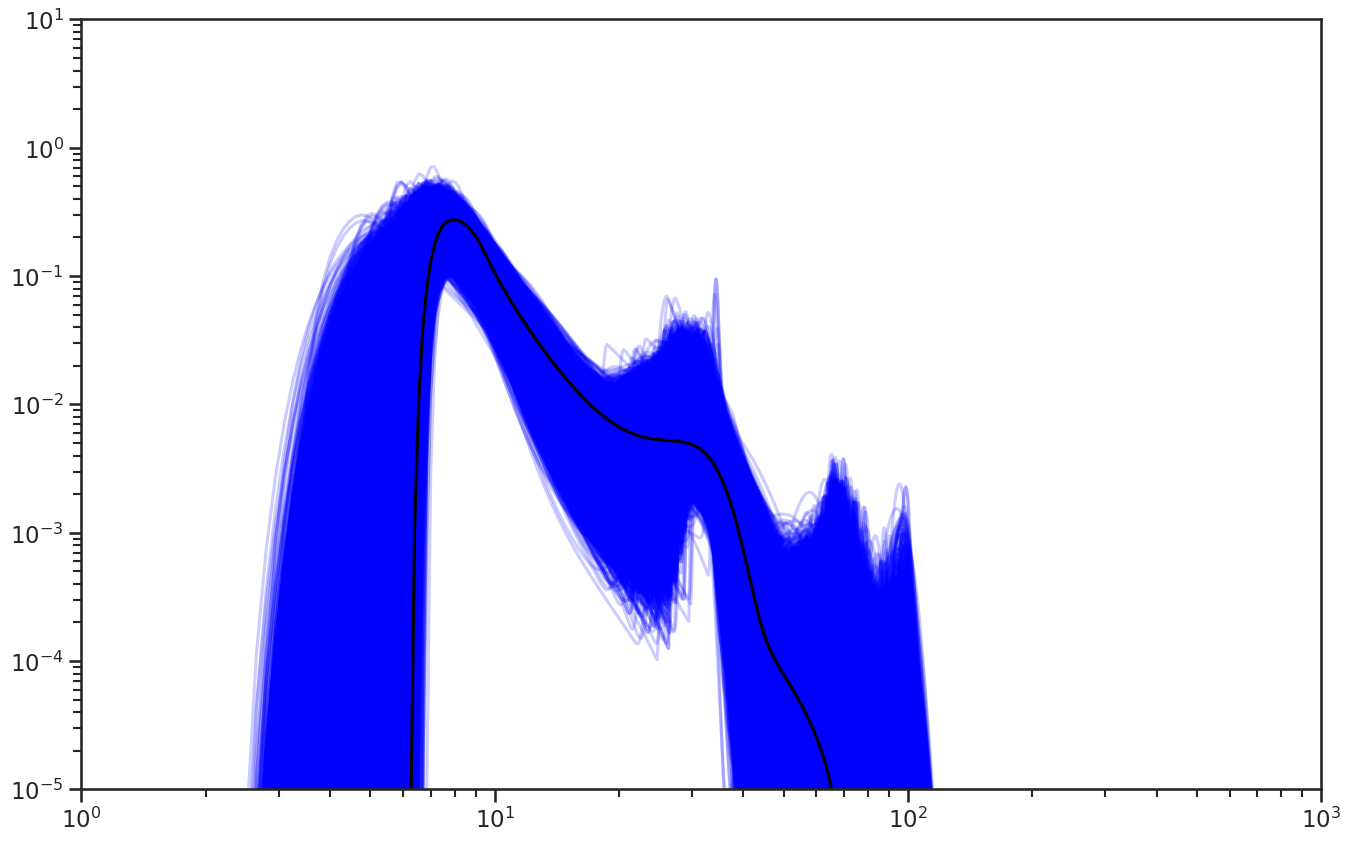

In [9]:
plt.figure()
for pm1_fit in tqdm(plplbump_pm1s):
    plt.loglog(ms,pm1_fit,alpha=0.2,color='green')    
plt.loglog(ms,pm1,color='black')
plt.xlim(1,1000)
plt.ylim(1e-5,10)
plt.show()

plt.figure()
for pm2_fit in tqdm(plplbump_pm2s):
    plt.loglog(ms,pm2_fit,alpha=0.2,color='blue')    
plt.loglog(ms,pm2,color='black')
plt.xlim(1,1000)
plt.ylim(1e-5,10)
plt.show()

In [10]:
dlogz_plpl = []
dlogz_plpl_err = []
post_samples_plpl = []

file = open('PLPL','rb')
dres = pickle.load(file)

dlogZdynesty = dres.logz[-1]        # value of logZ
dlogZerrdynesty = dres.logzerr[-1]  # estimate of the statistcal uncertainty on logZ

dlogz_plpl.append(dlogZdynesty)
dlogz_plpl_err.append(dlogZerrdynesty)

# output marginal likelihood
print('Marginalised evidence (using dynamic sampler) is {} ± {}'.format(dlogZdynesty, dlogZerrdynesty))

# get the posterior samples
dweights = np.exp(dres['logwt'] - dres['logz'][-1])
dpostsamples = resample_equal(dres.samples, dweights)
post_samples_plpl.append(dpostsamples)
print('Number of posterior samples (using dynamic sampler) is {}'.format(dpostsamples.shape[0]))


Marginalised evidence (using dynamic sampler) is -1518.9471207215815 ± 0.05905599152618848
Number of posterior samples (using dynamic sampler) is 67810


In [11]:
def log_pm1m2_powerlaw_powerlaw(m1,m2,m_min_1,m_max_1,alpha_1,dm_min_1,dm_max_1,m_min_2,m_max_2,alpha_2,dm_min_2,dm_max_2,f1,beta):
    log_dNdm1 = logpm1_powerlaw_powerlaw(m1,m_min_1,m_max_1,alpha_1,dm_min_1,dm_max_1,m_min_2,m_max_2,alpha_2,dm_min_2,dm_max_2,f1)
    log_dNdm2 = logpm1_powerlaw_powerlaw(m2,m_min_1,m_max_1,alpha_1,dm_min_1,dm_max_1,m_min_2,m_max_2,alpha_2,dm_min_2,dm_max_2,f1)
    log_fq = logfq(m1,m2,beta)
    return log_dNdm1 + log_dNdm2 + log_fq


plpl_pm1s = []
plpl_pm2s = []

for k in tqdm(range(len(post_samples_plpl[0]))):
    
    dpostsamples = post_samples_plpl[0][k]
    
    gamma_1 = dpostsamples[0]
    mmin_1 = dpostsamples[1]
    mmax_1 = dpostsamples[2]
    alpha_1 = dpostsamples[3]
    dm_mmin_1 = dpostsamples[4]
    dm_mmax_1 = dpostsamples[5]
    mmin_2 = dpostsamples[6]
    mmax_2 = dpostsamples[7]
    alpha_2 = dpostsamples[8]
    dm_mmin_2 = dpostsamples[9]
    dm_mmax_2 = dpostsamples[10]
    beta = dpostsamples[11]
    f1 = dpostsamples[12]
    
    pm1sm2s_fit = np.exp(log_pm1m2_powerlaw_powerlaw(m1s,m2s,mmin_1,mmax_1,alpha_1,dm_mmin_1,dm_mmax_1,mmin_2,mmax_2,alpha_2,dm_mmin_2,dm_mmax_2,f1,beta))
    pm1sm2s_fit[m1s<m2s]=0.
    pm1sm2s_fit/=np.trapz(np.trapz(pm1sm2s_fit,ms,axis=0),ms)    
    pm1_fit = np.trapz(pm1sm2s_fit,ms,axis=0)
    pm2_fit = np.trapz(pm1sm2s_fit,ms,axis=1)    
    pm1_fit = pm1_fit/np.trapz(pm1_fit,ms)
    pm2_fit = pm2_fit/np.trapz(pm2_fit,ms)
    plpl_pm1s.append(pm1_fit)
    plpl_pm2s.append(pm2_fit)


100%|██████████| 67810/67810 [31:53<00:00, 35.44it/s]


100%|██████████| 67810/67810 [00:32<00:00, 2073.42it/s]


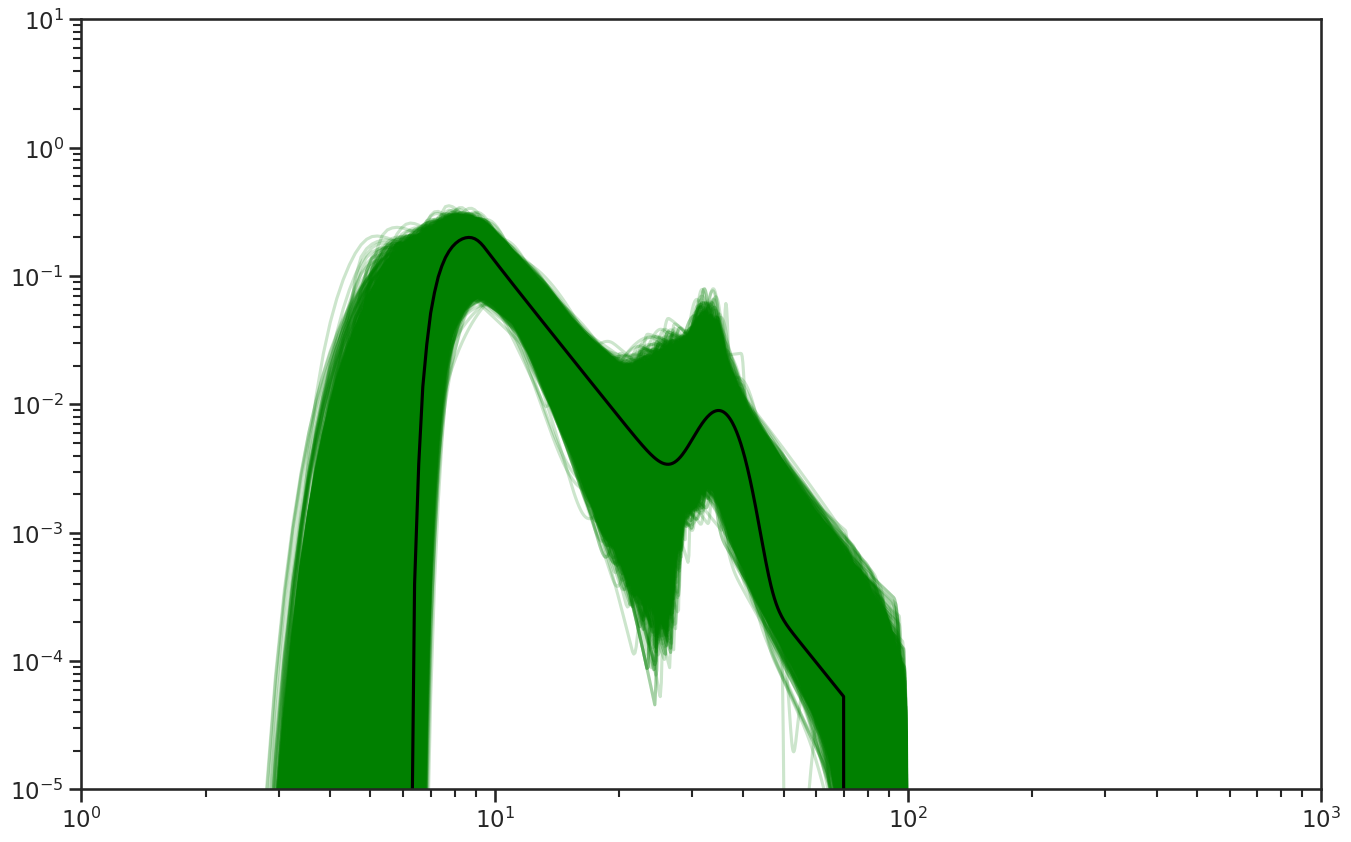

100%|██████████| 67810/67810 [00:30<00:00, 2229.48it/s]


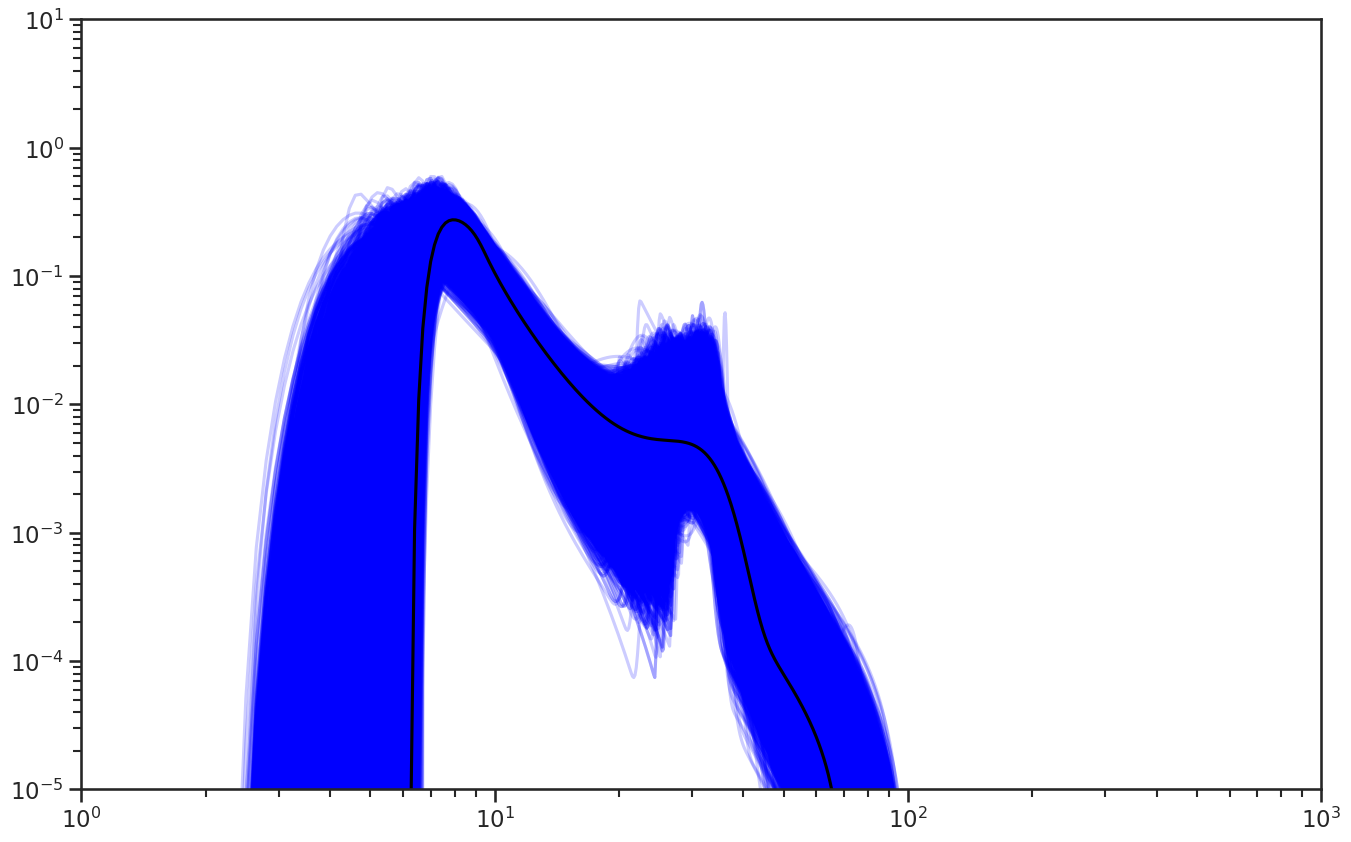

In [12]:
plt.figure()
for pm1_fit in tqdm(plpl_pm1s):
    plt.loglog(ms,pm1_fit,alpha=0.2,color='green')    
plt.loglog(ms,pm1,color='black')
plt.xlim(1,1000)
plt.ylim(1e-5,10)
plt.show()

plt.figure()
for pm2_fit in tqdm(plpl_pm2s):
    plt.loglog(ms,pm2_fit,alpha=0.2,color='blue')    
plt.loglog(ms,pm2,color='black')
plt.xlim(1,1000)
plt.ylim(1e-5,10)
plt.show()

In [13]:

plbump_pm1s_ = np.array(plbump_pm1s)

plbump_m1s_5 = np.percentile(plbump_pm1s_,q=5,axis=0)
plbump_m1s_95 = np.percentile(plbump_pm1s_,q=95,axis=0)
plbump_m1s_med = np.percentile(plbump_pm1s_,q=50,axis=0)


plplbump_pm1s_ = np.array(plplbump_pm1s)

plplbump_m1s_5 = np.percentile(plplbump_pm1s_,q=5,axis=0)
plplbump_m1s_95 = np.percentile(plplbump_pm1s_,q=95,axis=0)
plplbump_m1s_med = np.percentile(plplbump_pm1s_,q=50,axis=0)


plpl_pm1s_ = np.array(plpl_pm1s)

plpl_m1s_5 = np.percentile(plpl_pm1s_,q=5,axis=0)
plpl_m1s_95 = np.percentile(plpl_pm1s_,q=95,axis=0)
plpl_m1s_med = np.percentile(plpl_pm1s_,q=50,axis=0)


In [14]:

plbump_pm2s_ = np.array(plbump_pm2s)

plbump_m2s_5 = np.percentile(plbump_pm2s_,q=5,axis=0)
plbump_m2s_95 = np.percentile(plbump_pm2s_,q=95,axis=0)
plbump_m2s_med = np.percentile(plbump_pm2s_,q=50,axis=0)


plplbump_pm2s_ = np.array(plplbump_pm2s)

plplbump_m2s_5 = np.percentile(plplbump_pm2s_,q=5,axis=0)
plplbump_m2s_95 = np.percentile(plplbump_pm2s_,q=95,axis=0)
plplbump_m2s_med = np.percentile(plplbump_pm2s_,q=50,axis=0)


plpl_pm2s_ = np.array(plpl_pm2s)

plpl_m2s_5 = np.percentile(plpl_pm2s_,q=5,axis=0)
plpl_m2s_95 = np.percentile(plpl_pm2s_,q=95,axis=0)
plpl_m2s_med = np.percentile(plpl_pm2s_,q=50,axis=0)


dict_keys(['injected', 'lines', 'ppd'])
dict_keys(['mass_1', 'mass_ratio'])
['ms', 'pm1s', 'pm2s', 'pzs', 'zs']


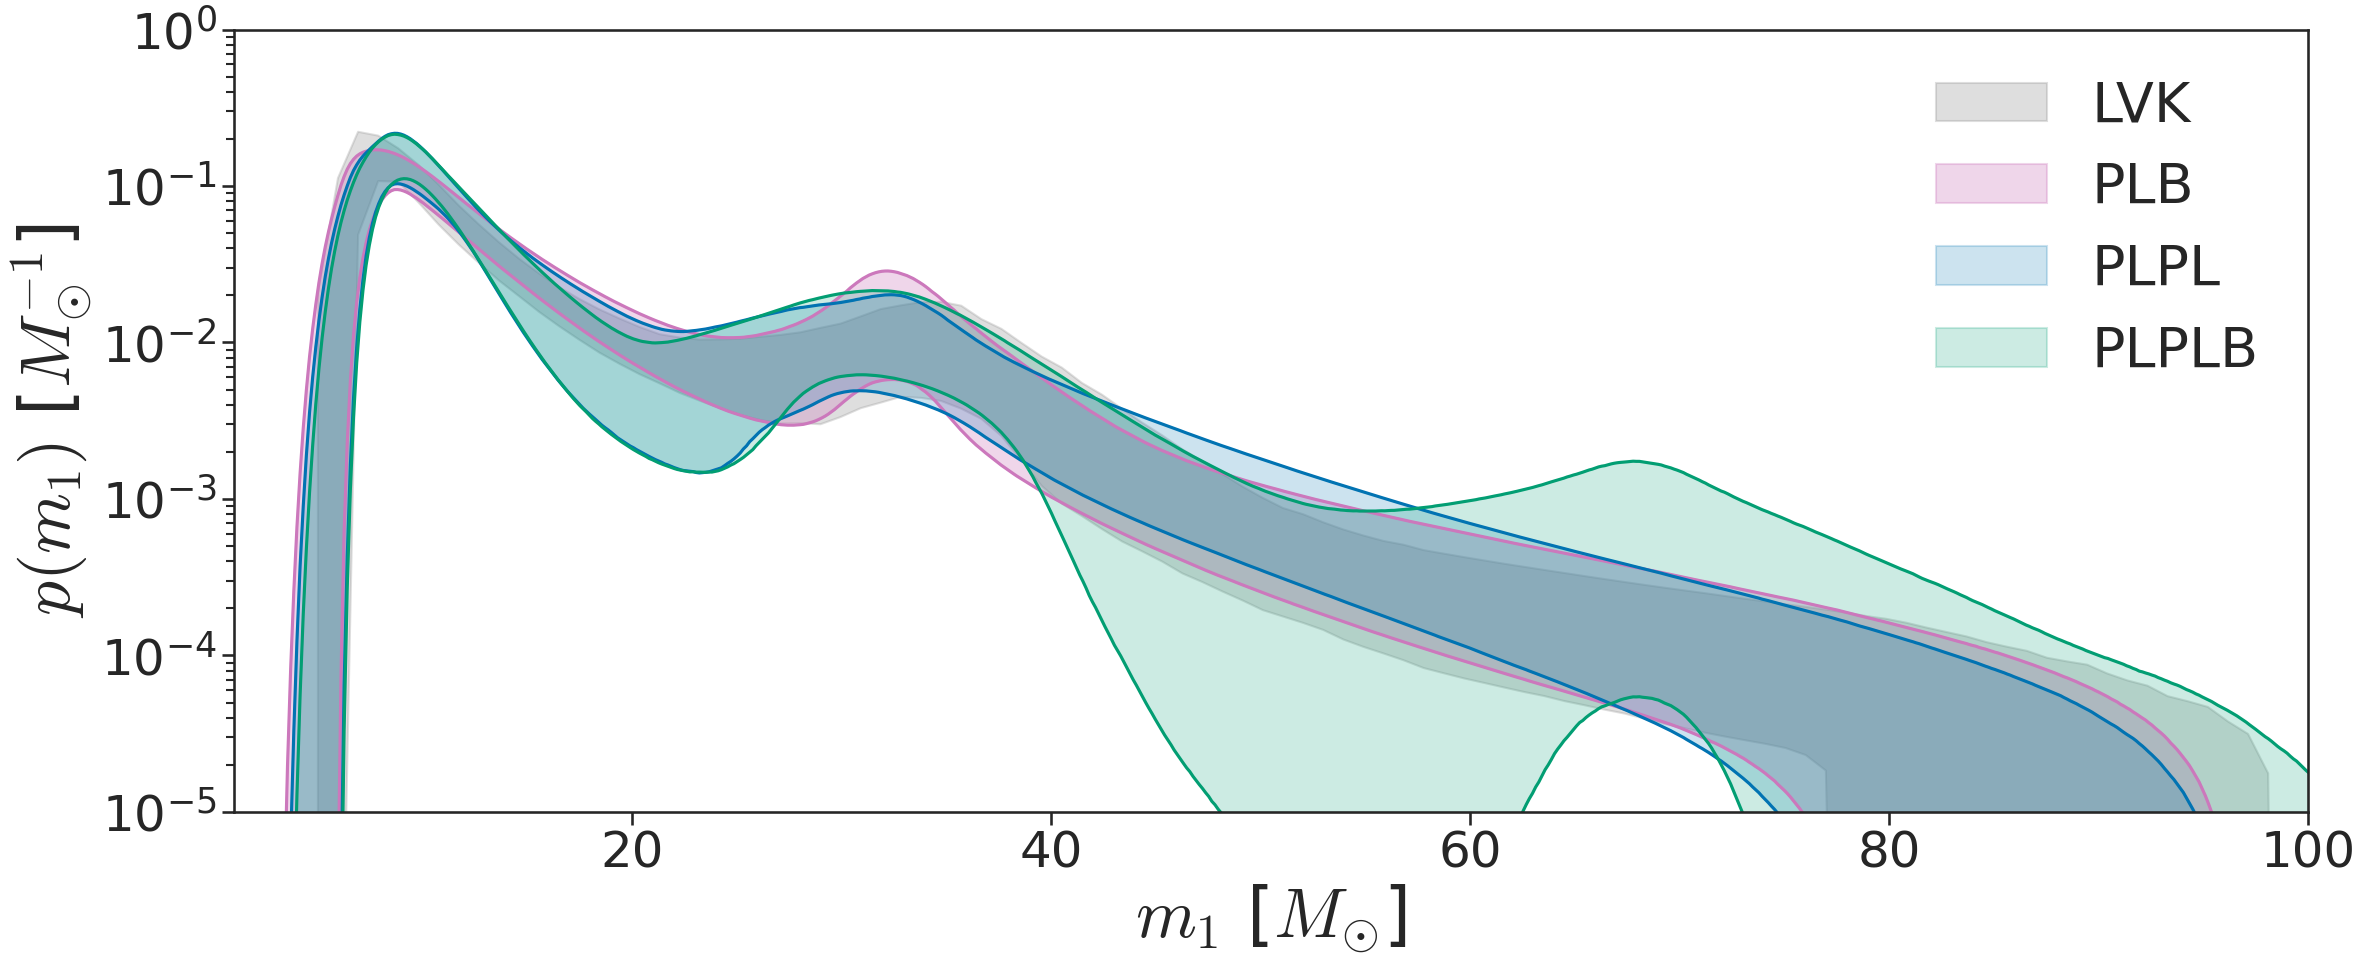

In [15]:
import deepdish as dd

mass_PP_path = '../../gppop/gwtc3/analyses/PowerLawPeak/o1o2o3_mass_c_iid_mag_iid_tilt_powerlaw_redshift_mass_data.h5'
with open(mass_PP_path, 'r') as _data:
    _data = dd.io.load(mass_PP_path)
    print(_data.keys())
    print(_data['lines'].keys())

with h5py.File('../../gppop/gwtc3/GWTC-3-param-pm1m2z.h5','r') as f:
    print(list(f.keys()))
    ms_ = np.array(f['ms'])
    zs = np.array(f['zs'])
    Rz = np.array(f['pzs'])
    Rpm1_GWTC3 = np.array(f['pm1s'])#*ms_
    Rpm2_GWTC3 = np.array(f['pm2s'])#*ms_
    
Rpm1_GWTC3/=np.trapz(Rpm1_GWTC3,ms_,axis=1)[:,None]
def mass_1_spectrum_plot(filenames, limits, labels):
    """
    Generates a plot of the PPD and X% credible region for the mass distribution,
    where X=limits[1]-limits[0]
    """
    mass_1 = np.linspace(2, 100, 1000)
    mass_ratio = np.linspace(0.1, 1, 500)
    mass_1_grid, mass_ratio_grid = np.meshgrid(mass_1, mass_ratio)

    fig, axs = plt.subplots(figsize=(24,10))

    for filename, label in zip(filenames, labels):
        with open(filename, 'r') as _data:
            _data = dd.io.load(filename)
            lines = _data["lines"]
            ppd = _data["ppd"]

        # marginalize over q to get the ppd in terms of m1 only
        mass_1_ppd = np.trapz(ppd, mass_ratio, axis=0)
        mass_1_ppd = mass_1_ppd / np.trapz(mass_1_ppd, mass_1)

        lines = lines['mass_1'] /  np.trapz(lines['mass_1'], mass_1)[:, np.newaxis]

        #marginalize over m1 to get the ppd in terms of q only
        mass_ratio_ppd = np.trapz(ppd, mass_1, axis=-1)
        mass_1_ppd = mass_1_ppd*mass_1 / np.trapz(mass_1_ppd*mass_1,mass_1)
        
#         axs.plot(ms_,np.percentile(Rpm1_GWTC3, limits[0], axis=0),color=c[7],ls='--',label="LVK")
#         axs.plot(ms_,np.percentile(Rpm1_GWTC3, limits[1], axis=0),color=c[7],ls='--')

        axs.fill_between(
            ms_,
            np.percentile(Rpm1_GWTC3, limits[0], axis=0),
            np.percentile(Rpm1_GWTC3, limits[1], axis=0),
            alpha=0.3, label=label, color=c[7]
        )


    axs.fill_between(ms,plbump_m1s_5,plbump_m1s_95,alpha=0.3,color=c[4],label="PLB")
    axs.plot(ms,plbump_m1s_5,color=c[4])
    axs.plot(ms,plbump_m1s_95,color=c[4])
    axs.fill_between(ms,plpl_m1s_5,plpl_m1s_95,alpha=0.2,color=c[0],label="PLPL")
    axs.plot(ms,plpl_m1s_5,color=c[0])
    axs.plot(ms,plpl_m1s_95,color=c[0])
    axs.fill_between(ms,plplbump_m1s_5,plplbump_m1s_95,alpha=0.2,color=c[2],label="PLPLB")
    axs.plot(ms,plplbump_m1s_5,color=c[2])
    axs.plot(ms,plplbump_m1s_95,color=c[2])
    axs.set_xlim(1,100)
    axs.set_ylim(1e-5,1)
    axs.set_xlabel("$m_{1}$ [$M_{\\odot}$]",fontsize=50)
    axs.legend(loc="best",fontsize=40,frameon=False)
    ylabel = "$p(m_1)$ [$M_{\\odot}^{-1}$]"
    axs.set_ylabel(ylabel,fontsize=50)
    plt.xticks(fontsize=36)
    plt.yticks(fontsize=36)
    axs.set_yscale('log')
    plt.tight_layout()
    return fig
    
fig = mass_1_spectrum_plot([mass_PP_path], limits=[5,95], labels=['LVK'])
plt.savefig('figure1_m1_normed.pdf')
plt.show()

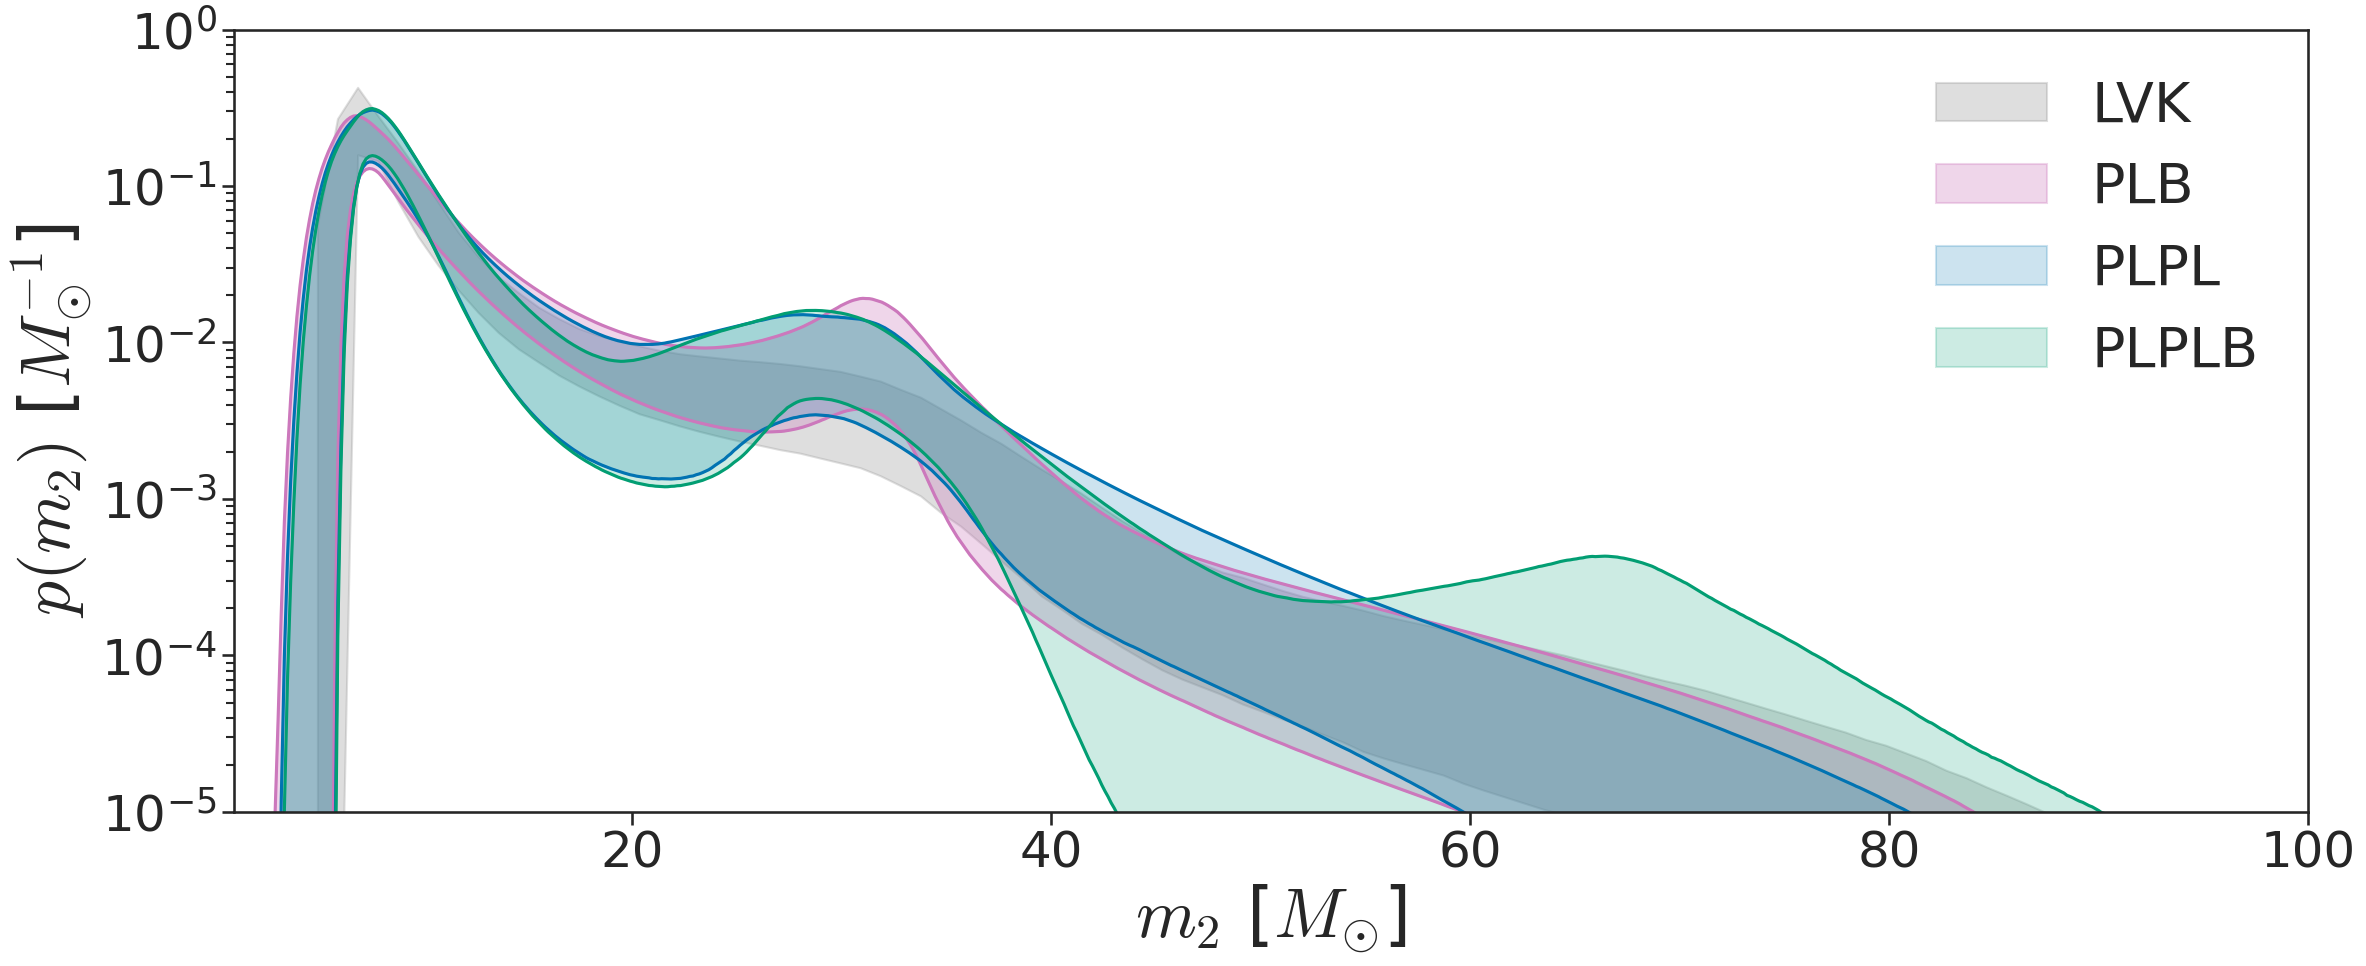

In [16]:
Rpm2_GWTC3/=np.trapz(Rpm2_GWTC3,ms_,axis=1)[:,None]
def mass_2_spectrum_plot(filenames, limits, labels):
    """
    Generates a plot of the PPD and X% credible region for the mass distribution,
    where X=limits[1]-limits[0]
    """
    mass_1 = np.linspace(2, 100, 1000)
    mass_ratio = np.linspace(0.1, 1, 500)
    mass_1_grid, mass_ratio_grid = np.meshgrid(mass_1, mass_ratio)

    fig, axs = plt.subplots(figsize=(24,10))

    for filename, label in zip(filenames, labels):
        with open(filename, 'r') as _data:
            _data = dd.io.load(filename)
            lines = _data["lines"]
            ppd = _data["ppd"]

        # marginalize over m1 to get the ppd in terms of q only
        mass_ratio_ppd = np.trapz(ppd, mass_1, axis=-1)
        #mass_ratio_ppd = mass_ratio_ppd / np.trapz(mass_ratio_ppd,mass_ratio)
        lines = lines['mass_ratio'] /  np.trapz(lines['mass_ratio'], mass_ratio)[:, np.newaxis]

        axs.fill_between(
            ms_,
            np.percentile(Rpm2_GWTC3, limits[0], axis=0),
            np.percentile(Rpm2_GWTC3, limits[1], axis=0),
            alpha=0.3, label=label, color=c[7]
        )


    axs.fill_between(ms,plbump_m2s_5,plbump_m2s_95,alpha=0.3,color=c[4],label="PLB")
    axs.plot(ms,plbump_m2s_5,color=c[4])
    axs.plot(ms,plbump_m2s_95,color=c[4])
    axs.fill_between(ms,plpl_m2s_5,plpl_m2s_95,alpha=0.2,color=c[0],label="PLPL")
    axs.plot(ms,plpl_m2s_5,color=c[0])
    axs.plot(ms,plpl_m2s_95,color=c[0])
    axs.fill_between(ms,plplbump_m2s_5,plplbump_m2s_95,alpha=0.2,color=c[2],label="PLPLB")
    axs.plot(ms,plplbump_m2s_5,color=c[2])
    axs.plot(ms,plplbump_m2s_95,color=c[2])
    axs.set_xlim(1,100)
    axs.set_ylim(1e-5,1)
    axs.set_xlabel("$m_{2}$ [$M_{\\odot}$]",fontsize=50)
    axs.legend(loc="best",fontsize=40,frameon=False)
    ylabel = "$p(m_2)$ [$M_{\\odot}^{-1}$]"
    axs.set_ylabel(ylabel,fontsize=50)
    plt.xticks(fontsize=36)
    plt.yticks(fontsize=36)
    axs.set_yscale('log')
    plt.tight_layout()
    return fig
    
fig = mass_2_spectrum_plot([mass_PP_path], limits=[5,95], labels=['LVK'])
plt.savefig('figure1_m2_normed.pdf')
plt.show()


In [17]:
def log_pm1m2_powerlaw_powerlaw(m1,m2,m_min_1,m_max_1,alpha_1,dm_min_1,dm_max_1,m_min_2,m_max_2,alpha_2,dm_min_2,dm_max_2,f1,beta):
    log_dNdm1 = logpm1_powerlaw_powerlaw(m1,m_min_1,m_max_1,alpha_1,dm_min_1,dm_max_1,m_min_2,m_max_2,alpha_2,dm_min_2,dm_max_2,f1)
    log_dNdm2 = logpm1_powerlaw_powerlaw(m2,m_min_1,m_max_1,alpha_1,dm_min_1,dm_max_1,m_min_2,m_max_2,alpha_2,dm_min_2,dm_max_2,f1)
    log_fq = logfq(m1,m2,beta)
    return log_dNdm1 + log_dNdm2 + log_fq


plpl_pm1s_pl1 = []
plpl_pm2s_pl1 = []

plpl_pm1s_pl2 = []
plpl_pm2s_pl2 = []
for k in tqdm(range(len(post_samples_plpl[0]))):
    
    dpostsamples = post_samples_plpl[0][k]
    
    gamma_1 = dpostsamples[0]
    mmin_1 = dpostsamples[1]
    mmax_1 = dpostsamples[2]
    alpha_1 = dpostsamples[3]
    dm_mmin_1 = dpostsamples[4]
    dm_mmax_1 = dpostsamples[5]
    mmin_2 = dpostsamples[6]
    mmax_2 = dpostsamples[7]
    alpha_2 = dpostsamples[8]
    dm_mmin_2 = dpostsamples[9]
    dm_mmax_2 = dpostsamples[10]
    beta = dpostsamples[11]
    f1 = dpostsamples[12]
    
    pm1sm2s_fit = np.exp(log_pm1m2_powerlaw_powerlaw(m1s,m2s,mmin_1,mmax_1,alpha_1,dm_mmin_1,dm_mmax_1,mmin_2,mmax_2,alpha_2,dm_mmin_2,dm_mmax_2,1,beta))
    pm1sm2s_fit[m1s<m2s]=0.
    pm1sm2s_fit/=np.trapz(np.trapz(pm1sm2s_fit,ms,axis=0),ms)    
    pm1_fit = np.trapz(pm1sm2s_fit,ms,axis=0)
    pm2_fit = np.trapz(pm1sm2s_fit,ms,axis=1)    
    pm1_fit = pm1_fit/np.trapz(pm1_fit,ms)
    pm2_fit = pm2_fit/np.trapz(pm2_fit,ms)
    plpl_pm1s_pl1.append(f1*pm1_fit)
    plpl_pm2s_pl1.append(f1*pm2_fit)

    pm1sm2s_fit = np.exp(log_pm1m2_powerlaw_powerlaw(m1s,m2s,mmin_1,mmax_1,alpha_1,dm_mmin_1,dm_mmax_1,mmin_2,mmax_2,alpha_2,dm_mmin_2,dm_mmax_2,0,beta))
    pm1sm2s_fit[m1s<m2s]=0.
    pm1sm2s_fit/=np.trapz(np.trapz(pm1sm2s_fit,ms,axis=0),ms)    
    pm1_fit = np.trapz(pm1sm2s_fit,ms,axis=0)
    pm2_fit = np.trapz(pm1sm2s_fit,ms,axis=1)    
    pm1_fit = pm1_fit/np.trapz(pm1_fit,ms)
    pm2_fit = pm2_fit/np.trapz(pm2_fit,ms)
    plpl_pm1s_pl2.append((1-f1)*pm1_fit)
    plpl_pm2s_pl2.append((1-f2)*pm2_fit)

100%|██████████| 67810/67810 [1:03:06<00:00, 17.91it/s]


In [18]:
plpl_pm1s_ = np.array(plpl_pm1s_pl1)

plpl_m1s_5_pl1 = np.percentile(plpl_pm1s_,q=5,axis=0)
plpl_m1s_95_pl1 = np.percentile(plpl_pm1s_,q=95,axis=0)
plpl_m1s_med_pl1 = np.percentile(plpl_pm1s_,q=50,axis=0)

plpl_pm1s_ = np.array(plpl_pm1s_pl2)

plpl_m1s_5_pl2 = np.percentile(plpl_pm1s_,q=5,axis=0)
plpl_m1s_95_pl2 = np.percentile(plpl_pm1s_,q=95,axis=0)
plpl_m1s_med_pl2 = np.percentile(plpl_pm1s_,q=50,axis=0)

In [19]:
import deepdish as dd

mass_PP_path = '../../gppop/gwtc3/analyses/PowerLawPeak/o1o2o3_mass_c_iid_mag_iid_tilt_powerlaw_redshift_mass_data.h5'
with open(mass_PP_path, 'r') as _data:
    _data = dd.io.load(mass_PP_path)
    print(_data.keys())
    print(_data['lines'].keys())

with h5py.File('../../gppop/gwtc3/GWTC-3-param-pm1m2z.h5','r') as f:
    print(list(f.keys()))
    ms_ = np.array(f['ms'])
    zs = np.array(f['zs'])
    Rz = np.array(f['pzs'])
    Rpm1_GWTC3 = np.array(f['pm1s'])#*ms_
    Rpm2_GWTC3 = np.array(f['pm2s'])#*ms_
    
Rpm1_GWTC3/=np.trapz(Rpm1_GWTC3,ms_,axis=1)[:,None]
def mass_1_spectrum_plot(filenames, limits, labels):
    """
    Generates a plot of the PPD and X% credible region for the mass distribution,
    where X=limits[1]-limits[0]
    """
    mass_1 = np.linspace(2, 100, 1000)
    mass_ratio = np.linspace(0.1, 1, 500)
    mass_1_grid, mass_ratio_grid = np.meshgrid(mass_1, mass_ratio)

    fig, axs = plt.subplots(figsize=(16,10))

    for filename, label in zip(filenames, labels):
        with open(filename, 'r') as _data:
            _data = dd.io.load(filename)
            lines = _data["lines"]
            ppd = _data["ppd"]

        # marginalize over q to get the ppd in terms of m1 only
        mass_1_ppd = np.trapz(ppd, mass_ratio, axis=0)
        mass_1_ppd = mass_1_ppd / np.trapz(mass_1_ppd, mass_1)

        lines = lines['mass_1'] /  np.trapz(lines['mass_1'], mass_1)[:, np.newaxis]

        #marginalize over m1 to get the ppd in terms of q only
        mass_ratio_ppd = np.trapz(ppd, mass_1, axis=-1)
        mass_1_ppd = mass_1_ppd*mass_1 / np.trapz(mass_1_ppd*mass_1,mass_1)

        axs.fill_between(
            ms_,
            np.percentile(Rpm1_GWTC3, limits[0], axis=0),
            np.percentile(Rpm1_GWTC3, limits[1], axis=0),
            alpha=0.3, label=label, color=c[7]
        )


    axs.fill_between(ms,plpl_m1s_5_pl1,plpl_m1s_95_pl1,alpha=0.2,color=c[4],label="PL1")
    axs.fill_between(ms,plpl_m1s_5_pl2,plpl_m1s_95_pl2,alpha=0.2,color=c[2],label="PL2")
    axs.set_xlim(1,100)
    axs.set_ylim(1e-5,10)
    axs.set_xlabel("$m_{1}$ [$M_{\\odot}$]",fontsize=50)
    axs.legend(loc="best",fontsize=40,frameon=False)
    ylabel = "$p(m_1)$ [$M_{\\odot}^{-1}$]"
    axs.set_ylabel(ylabel,fontsize=50)
    plt.xticks(fontsize=36)
    plt.yticks(fontsize=36)
    axs.set_yscale('log')
    plt.tight_layout()
    return fig
    
fig = mass_1_spectrum_plot([mass_PP_path], limits=[5,95], labels=['LVK'])


dict_keys(['injected', 'lines', 'ppd'])
dict_keys(['mass_1', 'mass_ratio'])
['ms', 'pm1s', 'pm2s', 'pzs', 'zs']


In [20]:
def log_pm1m2_powerlaw_powerlaw_peak(m1,m2,m_min_1,m_max_1,alpha_1,dm_min_1,dm_max_1,m_min_2,m_max_2,alpha_2,dm_min_2,dm_max_2,mu,sigma,f1,f2,beta):
    log_dNdm1 = logpm1_powerlaw_powerlaw_peak(m1,m_min_1,m_max_1,alpha_1,dm_min_1,dm_max_1,m_min_2,m_max_2,alpha_2,dm_min_2,dm_max_2,mu,sigma,f1,f2)
    log_dNdm2 = logpm1_powerlaw_powerlaw_peak(m2,m_min_1,m_max_1,alpha_1,dm_min_1,dm_max_1,m_min_2,m_max_2,alpha_2,dm_min_2,dm_max_2,mu,sigma,f1,f2)
    log_fq = logfq(m1,m2,beta)
    return log_dNdm1 + log_dNdm2 + log_fq


plplbump_pm1s_pl1 = []
plplbump_pm2s_pl1 = []
plplbump_pm1s_pl2 = []
plplbump_pm2s_pl2 = []
plplbump_pm1s_bump = []
plplbump_pm2s_bump = []
for k in tqdm(range(len(post_samples_plplbump[0]))):
    
    dpostsamples = post_samples_plplbump[0][k]
    
    gamma_1 = dpostsamples[0]
    mmin_1 = dpostsamples[1]
    mmax_1 = dpostsamples[2]
    alpha_1 = dpostsamples[3]
    dm_mmin_1 = dpostsamples[4]
    dm_mmax_1 = dpostsamples[5]
    mmin_2 = dpostsamples[6]
    mmax_2 = dpostsamples[7]
    alpha_2 = dpostsamples[8]
    dm_mmin_2 = dpostsamples[9]
    dm_mmax_2 = dpostsamples[10]
    beta = dpostsamples[11]
    mu = dpostsamples[12]
    sigma = dpostsamples[13]
    f1 = dpostsamples[14]
    f2 = dpostsamples[15]
    
    pm1sm2s_fit = np.exp(log_pm1m2_powerlaw_powerlaw_peak(m1s,m2s,mmin_1,mmax_1,alpha_1,dm_mmin_1,dm_mmax_1,mmin_2,mmax_2,alpha_2,dm_mmin_2,dm_mmax_2,mu,sigma,1,0,beta))
    pm1sm2s_fit[m1s<m2s]=0.
    pm1sm2s_fit/=np.trapz(np.trapz(pm1sm2s_fit,ms,axis=0),ms)    
    pm1_fit = np.trapz(pm1sm2s_fit,ms,axis=0)
    pm2_fit = np.trapz(pm1sm2s_fit,ms,axis=1)    
    pm1_fit = pm1_fit/np.trapz(pm1_fit,ms)
    pm2_fit = pm2_fit/np.trapz(pm2_fit,ms)
    plplbump_pm1s_pl1.append(f1*pm1_fit)
    plplbump_pm2s_pl1.append(f1*pm2_fit)
    
    pm1sm2s_fit = np.exp(log_pm1m2_powerlaw_powerlaw_peak(m1s,m2s,mmin_1,mmax_1,alpha_1,dm_mmin_1,dm_mmax_1,mmin_2,mmax_2,alpha_2,dm_mmin_2,dm_mmax_2,mu,sigma,0,1,beta))
    pm1sm2s_fit[m1s<m2s]=0.
    pm1sm2s_fit/=np.trapz(np.trapz(pm1sm2s_fit,ms,axis=0),ms)    
    pm1_fit = np.trapz(pm1sm2s_fit,ms,axis=0)
    pm2_fit = np.trapz(pm1sm2s_fit,ms,axis=1)    
    pm1_fit = pm1_fit/np.trapz(pm1_fit,ms)
    pm2_fit = pm2_fit/np.trapz(pm2_fit,ms)
    plplbump_pm1s_pl2.append(f2*pm1_fit)
    plplbump_pm2s_pl2.append(f2*pm2_fit)
    
    pm1sm2s_fit = np.exp(log_pm1m2_powerlaw_powerlaw_peak(m1s,m2s,mmin_1,mmax_1,alpha_1,dm_mmin_1,dm_mmax_1,mmin_2,mmax_2,alpha_2,dm_mmin_2,dm_mmax_2,mu,sigma,0,0,beta))
    pm1sm2s_fit[m1s<m2s]=0.
    pm1sm2s_fit/=np.trapz(np.trapz(pm1sm2s_fit,ms,axis=0),ms)    
    pm1_fit = np.trapz(pm1sm2s_fit,ms,axis=0)
    pm2_fit = np.trapz(pm1sm2s_fit,ms,axis=1)    
    pm1_fit = pm1_fit/np.trapz(pm1_fit,ms)
    pm2_fit = pm2_fit/np.trapz(pm2_fit,ms)
    plplbump_pm1s_bump.append((1-f1-f2)*pm1_fit)
    plplbump_pm2s_bump.append((1-f1-f2)*pm2_fit)


100%|██████████| 69693/69693 [1:39:34<00:00, 11.67it/s]  


In [21]:
plplbump_pm1s_ = np.array(plplbump_pm1s_pl1)

plplbump_m1s_5_pl1 = np.percentile(plplbump_pm1s_,q=5,axis=0)
plplbump_m1s_95_pl1 = np.percentile(plplbump_pm1s_,q=95,axis=0)
plplbump_m1s_med_pl1 = np.percentile(plplbump_pm1s_,q=50,axis=0)

plplbump_pm1s_ = np.array(plplbump_pm1s_pl2)

plplbump_m1s_5_pl2 = np.percentile(plplbump_pm1s_,q=5,axis=0)
plplbump_m1s_95_pl2 = np.percentile(plplbump_pm1s_,q=95,axis=0)
plplbump_m1s_med_pl2 = np.percentile(plplbump_pm1s_,q=50,axis=0)

plplbump_pm1s_ = np.array(plplbump_pm1s_bump)

plplbump_m1s_5_bump = np.percentile(plplbump_pm1s_,q=5,axis=0)
plplbump_m1s_95_bump = np.percentile(plplbump_pm1s_,q=95,axis=0)
plplbump_m1s_med_bump = np.percentile(plplbump_pm1s_,q=50,axis=0)

plplbump_pm1s_ = np.array(plplbump_pm2s_pl1)

plplbump_m2s_5_pl1 = np.percentile(plplbump_pm1s_,q=5,axis=0)
plplbump_m2s_95_pl1 = np.percentile(plplbump_pm1s_,q=95,axis=0)
plplbump_m2s_med_pl1 = np.percentile(plplbump_pm1s_,q=50,axis=0)

plplbump_pm1s_ = np.array(plplbump_pm2s_pl2)

plplbump_m2s_5_pl2 = np.percentile(plplbump_pm1s_,q=5,axis=0)
plplbump_m2s_95_pl2 = np.percentile(plplbump_pm1s_,q=95,axis=0)
plplbump_m2s_med_pl2 = np.percentile(plplbump_pm1s_,q=50,axis=0)

plplbump_pm1s_ = np.array(plplbump_pm2s_bump)

plplbump_m2s_5_bump = np.percentile(plplbump_pm1s_,q=5,axis=0)
plplbump_m2s_95_bump = np.percentile(plplbump_pm1s_,q=95,axis=0)
plplbump_m2s_med_bump = np.percentile(plplbump_pm1s_,q=50,axis=0)



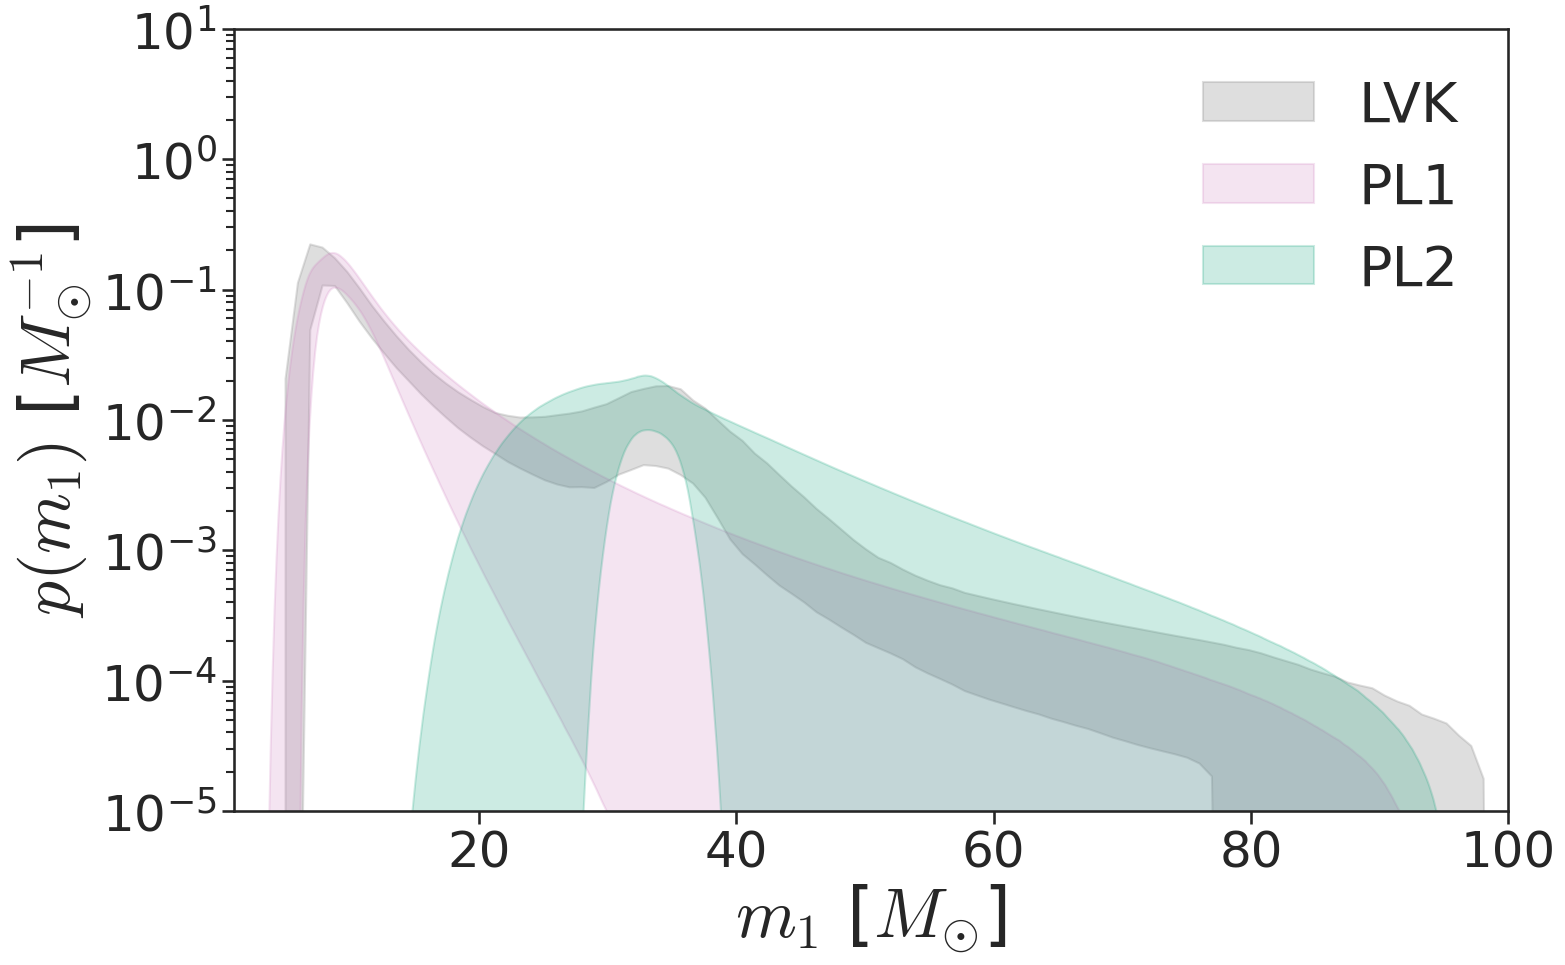

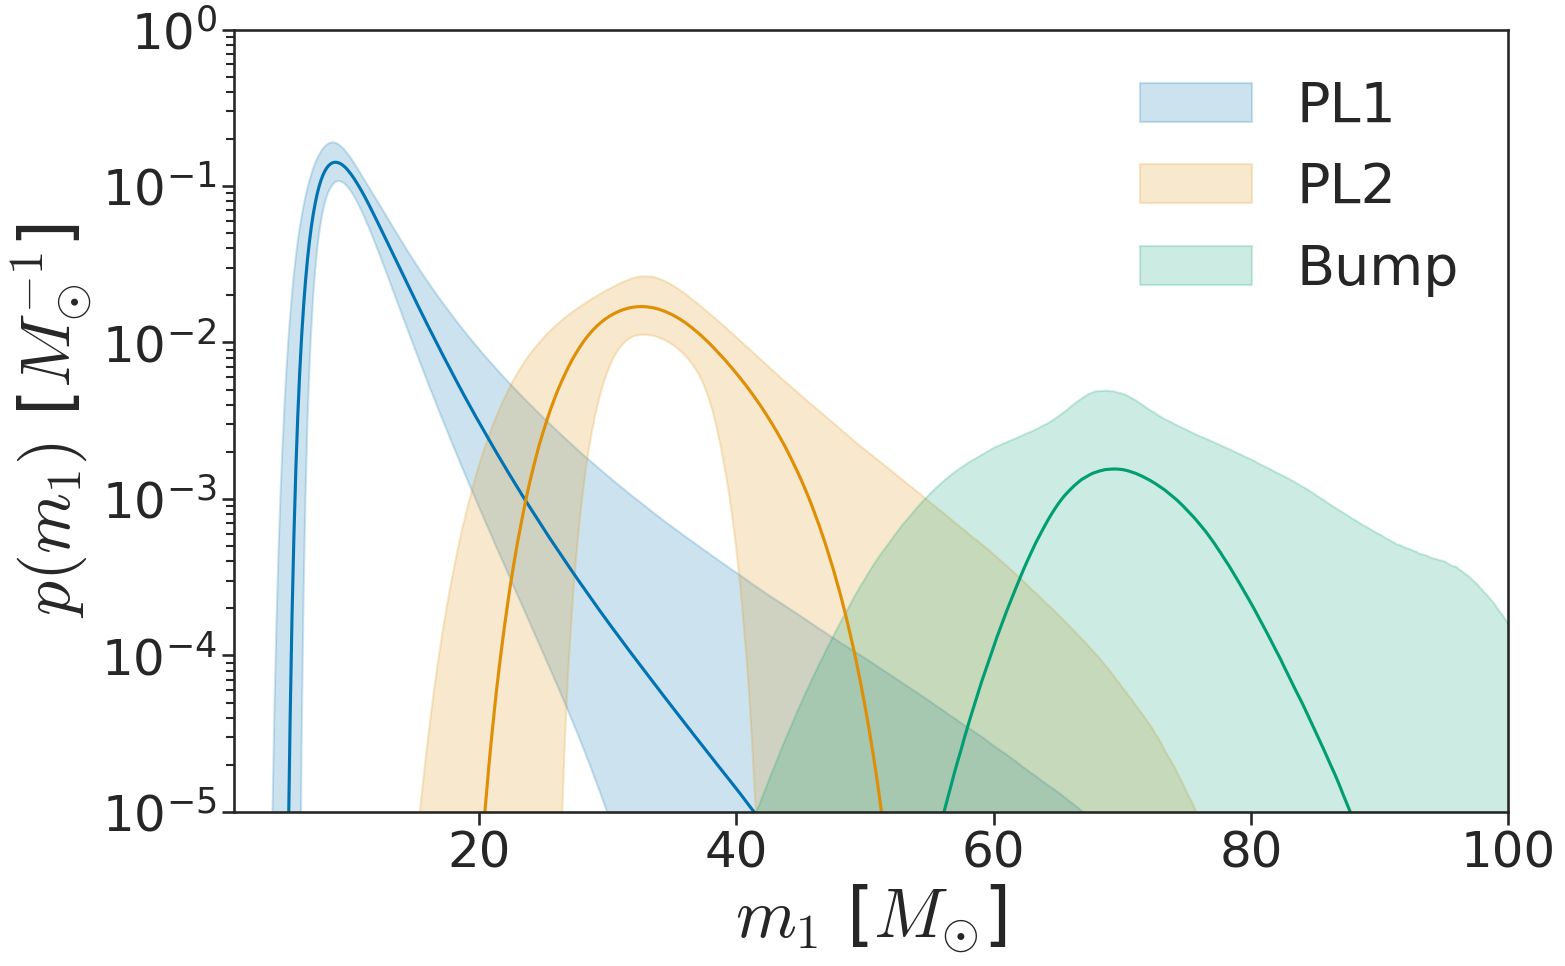

In [22]:

def mass_1_spectrum_plot(filenames, limits, labels):
    """
    Generates a plot of the PPD and X% credible region for the mass distribution,
    where X=limits[1]-limits[0]
    """

    fig, axs = plt.subplots(figsize=(16,10))

    axs.fill_between(ms,plplbump_m1s_5_pl1,plplbump_m1s_95_pl1,alpha=0.2,color=c[0],label="PL1")
    axs.plot(ms,plplbump_m1s_med_pl1,color=c[0])
    axs.fill_between(ms,plplbump_m1s_5_pl2,plplbump_m1s_95_pl2,alpha=0.2,color=c[1],label="PL2")
    axs.plot(ms,plplbump_m1s_med_pl2,color=c[1])
    axs.fill_between(ms,plplbump_m1s_5_bump,plplbump_m1s_95_bump,alpha=0.2,color=c[2],label="Bump")
    axs.plot(ms,plplbump_m1s_med_bump,color=c[2])
    axs.set_xlim(1,100)
    axs.set_ylim(1e-5,1)
    axs.set_xlabel("$m_{1}$ [$M_{\\odot}$]",fontsize=50)
    axs.legend(loc="best",fontsize=40,frameon=False)
    ylabel = "$p(m_1)$ [$M_{\\odot}^{-1}$]"
    axs.set_ylabel(ylabel,fontsize=50)
    plt.xticks(fontsize=36)
    plt.yticks(fontsize=36)
    axs.set_yscale('log')
    plt.tight_layout()
    return fig
    
fig = mass_1_spectrum_plot([mass_PP_path], limits=[5,95], labels=['LVK'])
plt.savefig('figure1_m1_components_normed.pdf')
plt.show()

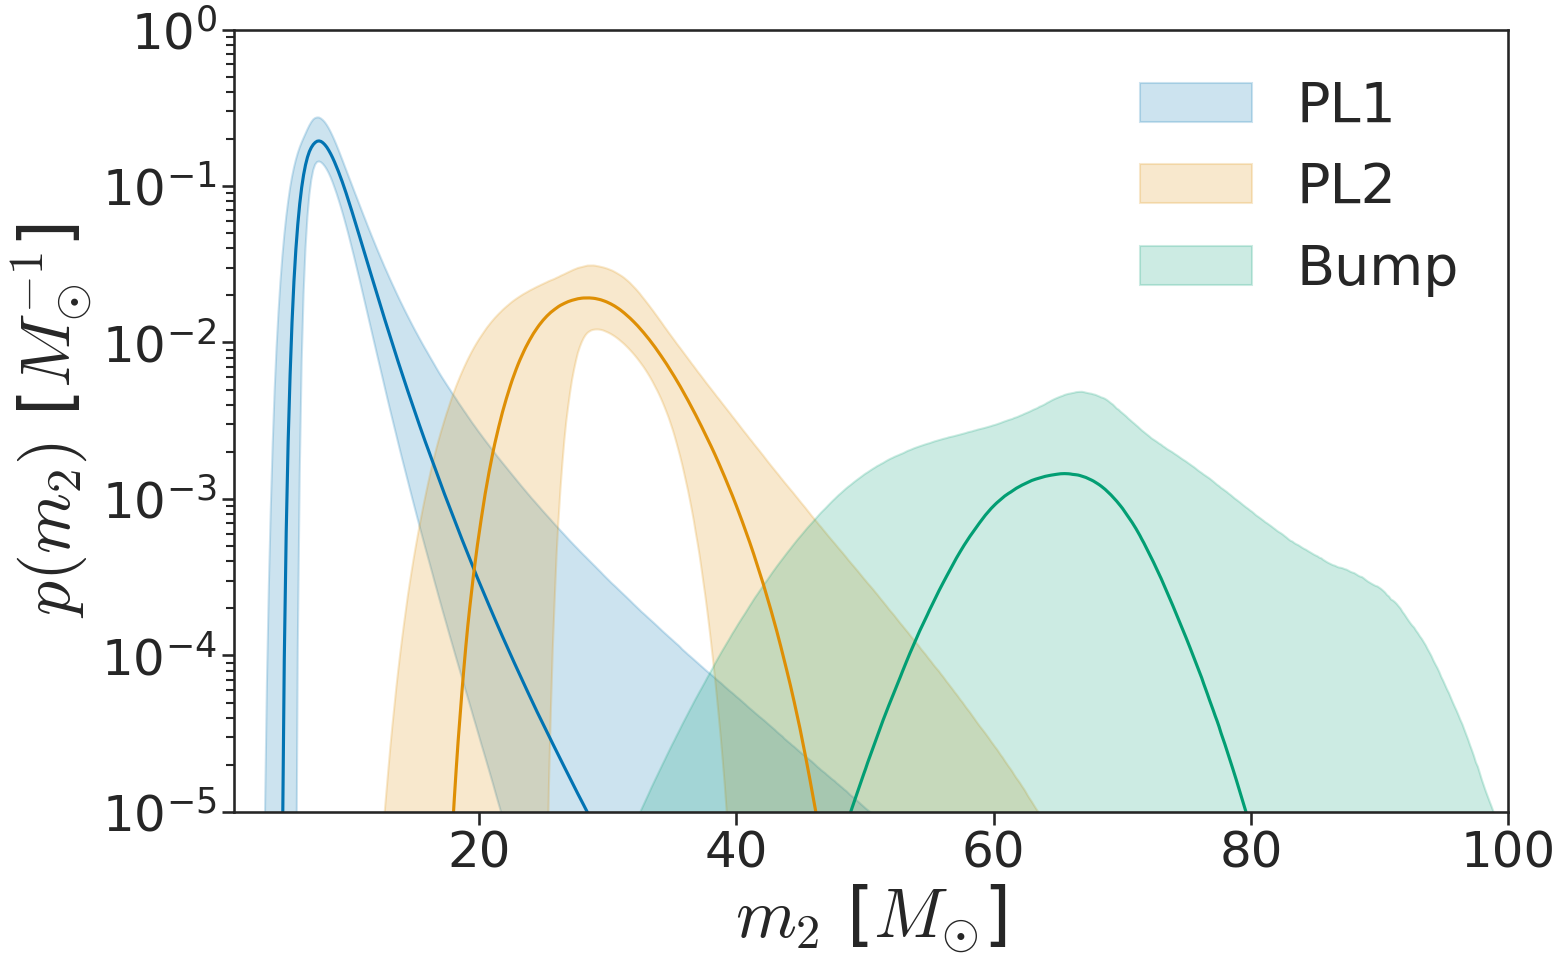

In [23]:

def mass_2_spectrum_plot(filenames, limits, labels):
    """
    Generates a plot of the PPD and X% credible region for the mass distribution,
    where X=limits[1]-limits[0]
    """

    fig, axs = plt.subplots(figsize=(16,10))

    axs.fill_between(ms,plplbump_m2s_5_pl1,plplbump_m2s_95_pl1,alpha=0.2,color=c[0],label="PL1")
    axs.plot(ms,plplbump_m2s_med_pl1,color=c[0])
    axs.fill_between(ms,plplbump_m2s_5_pl2,plplbump_m2s_95_pl2,alpha=0.2,color=c[1],label="PL2")
    axs.plot(ms,plplbump_m2s_med_pl2,color=c[1])
    axs.fill_between(ms,plplbump_m2s_5_bump,plplbump_m2s_95_bump,alpha=0.2,color=c[2],label="Bump")
    axs.plot(ms,plplbump_m2s_med_bump,color=c[2])
#     axs.plot(ms,plplbump_m2s_5_pl1+plplbump_m2s_5_pl2+plplbump_m2s_5_bump,color='k')
#     axs.plot(ms,plplbump_m2s_95_pl1*plplbump_m2s_95_pl2*plplbump_m2s_95_bump,color='k')
    axs.set_xlim(1,100)
    axs.set_ylim(1e-5,1)
    axs.set_xlabel("$m_{2}$ [$M_{\\odot}$]",fontsize=50)
    axs.legend(loc="best",fontsize=40,frameon=False)
    ylabel = "$p(m_2)$ [$M_{\\odot}^{-1}$]"
    axs.set_ylabel(ylabel,fontsize=50)
    plt.xticks(fontsize=36)
    plt.yticks(fontsize=36)
    axs.set_yscale('log')
    plt.tight_layout()
    return fig
    
fig = mass_2_spectrum_plot([mass_PP_path], limits=[5,95], labels=['LVK'])
plt.savefig('figure1_m2_components_normed.pdf')
plt.show()